# Análisis RFM y K-Means para Aurora Marketplace
---

In [ ]:
# Análisis RFM y K-Means para Aurora Marketplace

# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from datetime import datetime
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')
import os 

# Configuración para visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("viridis")

# Ruta de la carpeta donde vamos a guardar nuestros resultados
output_folder = "resultados_obtenidos"

# Crear la carpeta si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Carpeta '{output_folder}' creada exitosamente.")
else:
    print(f"La carpeta '{output_folder}' ya existe.")

La carpeta 'resultados_obtenidos' ya existe.


In [2]:
# Establecemos semilla para reproducibilidad
np.random.seed(42)

# 1. CARGA Y EXPLORACIÓN INICIAL DE DATOS
print("1. CARGA Y EXPLORACIÓN DE DATOS")
print("-" * 50)

# Cargamos el dataset
url = 'https://storage.googleapis.com/bucket-mda11-business-cases/business-case-6/aurora_dataset.csv'
aurora_data = pd.read_csv(url)

# Mostramos las primeras filas
print("Primeras filas del dataset:")
display(aurora_data.head())

# Información general del dataset
print("\nInformación del dataset:")
display(aurora_data.info())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
display(aurora_data.describe())

# Verificamos valores nulos
print("\nValores nulos por columna:")
display(aurora_data.isnull().sum())

1. CARGA Y EXPLORACIÓN DE DATOS
--------------------------------------------------
Primeras filas del dataset:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2024-03-23,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2024-03-23,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2024-03-23,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2024-03-23,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2024-03-23,3.39,17850,United Kingdom



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  int64  
 7   Country      406829 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 24.8+ MB


None


Estadísticas descriptivas:


,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000



Valores nulos por columna:


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [3]:
# 2. PREPROCESAMIENTO DE DATOS
print("\n2. PREPROCESAMIENTO DE DATOS")
print("-" * 50)

# Convertimos la fecha a formato datetime
aurora_data['InvoiceDate'] = pd.to_datetime(aurora_data['InvoiceDate'])

# Verificamos si hay valores negativos en Quantity o UnitPrice
print("Valores negativos en Quantity:", (aurora_data['Quantity'] < 0).sum())
print("Valores negativos en UnitPrice:", (aurora_data['UnitPrice'] < 0).sum())

# Filtramos valores negativos si existen (posibles devoluciones)
aurora_data = aurora_data[(aurora_data['Quantity'] > 0) & (aurora_data['UnitPrice'] > 0)]

# Calculamos el valor total de cada transacción
aurora_data['TotalValue'] = aurora_data['Quantity'] * aurora_data['UnitPrice']

# Verificamos la antigüedad de los clientes
# Definimos la fecha de análisis como 31/03/2025
analysis_date = pd.to_datetime('2025-03-31')

# Calculamos la fecha de primera compra para cada cliente
customer_first_purchase = aurora_data.groupby('CustomerID')['InvoiceDate'].min().reset_index()
customer_first_purchase.columns = ['CustomerID', 'FirstPurchaseDate']

# Fusionamos con el dataset original
aurora_data = pd.merge(aurora_data, customer_first_purchase, on='CustomerID', how='left')

# Calculamos la antigüedad en días
aurora_data['CustomerAge'] = (analysis_date - aurora_data['FirstPurchaseDate']).dt.days

# Filtramos clientes con al menos 6 meses de antigüedad (aproximadamente 180 días)
min_age = 180
customers_6months = aurora_data[aurora_data['CustomerAge'] >= min_age]['CustomerID'].unique()
print(f"Clientes con al menos 6 meses de antigüedad: {len(customers_6months)}")

# Filtramos transacciones de los últimos 6 meses
six_months_ago = analysis_date - pd.DateOffset(months=6)
recent_data = aurora_data[
    (aurora_data['InvoiceDate'] >= six_months_ago) & 
    (aurora_data['InvoiceDate'] <= analysis_date) &
    (aurora_data['CustomerID'].isin(customers_6months))
]

print(f"Transacciones en los últimos 6 meses de clientes con +6 meses de antigüedad: {len(recent_data)}")


2. PREPROCESAMIENTO DE DATOS
--------------------------------------------------
Valores negativos en Quantity: 8905
Valores negativos en UnitPrice: 0
Clientes con al menos 6 meses de antigüedad: 2821
Transacciones en los últimos 6 meses de clientes con +6 meses de antigüedad: 168870


## CONSTRUCCIÓN DE MÉTRICAS RFM
---


3. CONSTRUCCIÓN DE MÉTRICAS RFM
--------------------------------------------------
Dimensiones del dataframe RFM: (1969, 4)

Primeras filas del dataframe RFM:
   CustomerID  Recency  Frequency  Monetary
0       12347        2          3   2104.05
1       12348       75          1    310.00
2       12352       36          3    944.23
3       12356       22          1     58.35
4       12359       57          1   2876.85

Estadísticas descriptivas de las métricas RFM (Recency, Frequency, Monetary):
           Recency    Frequency       Monetary
count  1969.000000  1969.000000    1969.000000
mean     45.055358     3.960894    2165.596237
std      45.156733     6.129861    8653.539632
min       0.000000     1.000000       7.900000
25%      10.000000     1.000000     358.000000
50%      29.000000     2.000000     793.880000
75%      67.000000     4.000000    1694.360000
max     182.000000   135.000000  168469.600000


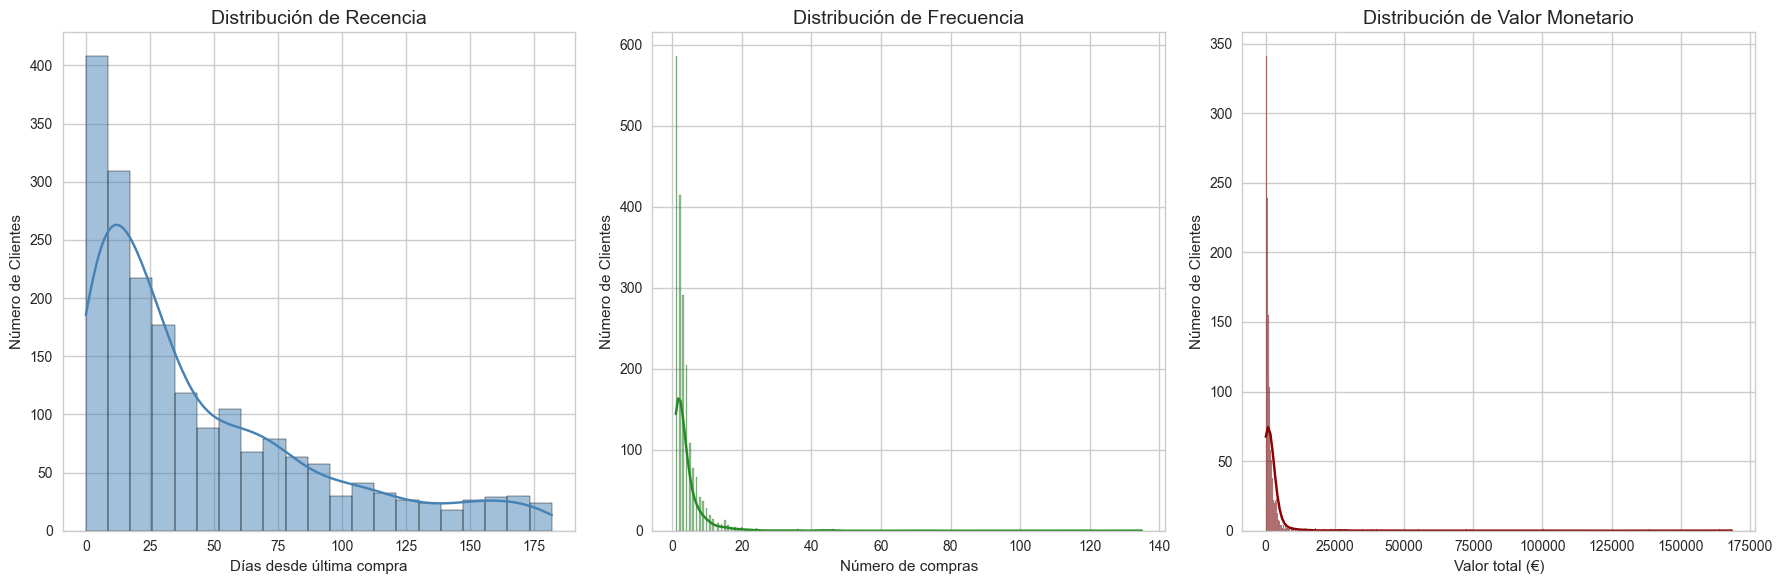

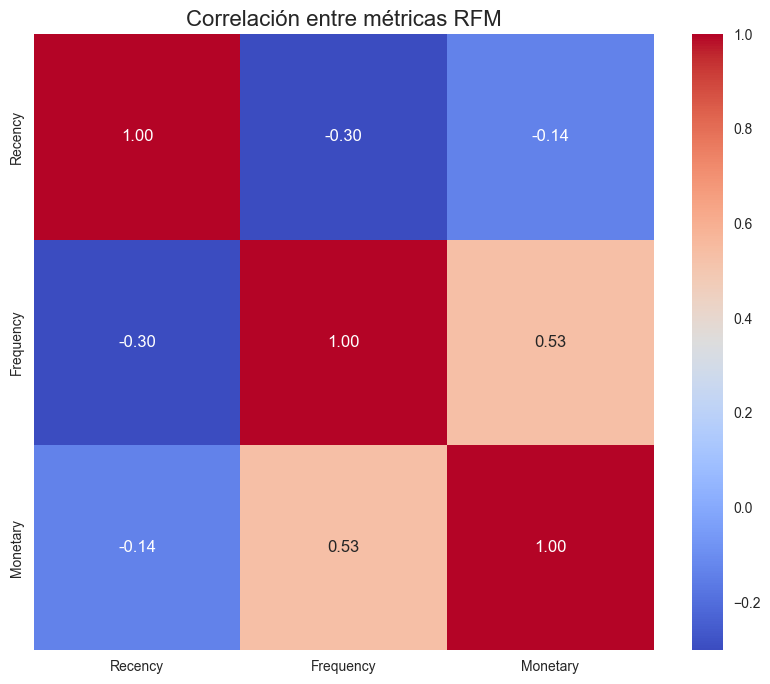

In [4]:
# 3. CONSTRUCCIÓN DE MÉTRICAS RFM (EJERCICIO 1)
print("\n3. CONSTRUCCIÓN DE MÉTRICAS RFM")
print("-" * 50)

# Recency: días desde la última compra hasta la fecha de análisis
recency_df = recent_data.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df.columns = ['CustomerID', 'LastPurchaseDate']
recency_df['Recency'] = (analysis_date - recency_df['LastPurchaseDate']).dt.days

# Frequency: número de compras (facturas únicas)
frequency_df = recent_data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

# Monetary: valor total gastado
monetary_df = recent_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']

# Creamos el dataframe RFM combinando las tres métricas
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

# Eliminamos columnas innecesarias y nos quedamos con las métricas RFM
rfm_final = rfm_df[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

print("Dimensiones del dataframe RFM:", rfm_final.shape)
print("\nPrimeras filas del dataframe RFM:")
print(rfm_final.head())

print("\nEstadísticas descriptivas de las métricas RFM (Recency, Frequency, Monetary):")
print(rfm_final[['Recency', 'Frequency', 'Monetary']].describe())

# Visualizamos la distribución de las métricas RFM
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Recency
sns.histplot(rfm_final['Recency'], kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Distribución de Recencia', fontsize=14)
axes[0].set_xlabel('Días desde última compra')
axes[0].set_ylabel('Número de Clientes')

# Frequency
sns.histplot(rfm_final['Frequency'], kde=True, ax=axes[1], color='forestgreen')
axes[1].set_title('Distribución de Frecuencia', fontsize=14)
axes[1].set_xlabel('Número de compras')
axes[1].set_ylabel('Número de Clientes')

# Monetary
sns.histplot(rfm_final['Monetary'], kde=True, ax=axes[2], color='darkred')
axes[2].set_title('Distribución de Valor Monetario', fontsize=14)
axes[2].set_xlabel('Valor total (€)')
axes[2].set_ylabel('Número de Clientes')

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'rfm_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

# Observamos la correlación entre las métricas
plt.figure(figsize=(10, 8))
correlation_matrix = rfm_final[['Recency', 'Frequency', 'Monetary']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre métricas RFM', fontsize=16)
plt.savefig(os.path.join(output_folder, 'rfm_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()

## ENTRENAMIENTO DEL MODELO K-MEANS
---


4. ENTRENAMIENTO DEL MODELO K-MEANS
--------------------------------------------------


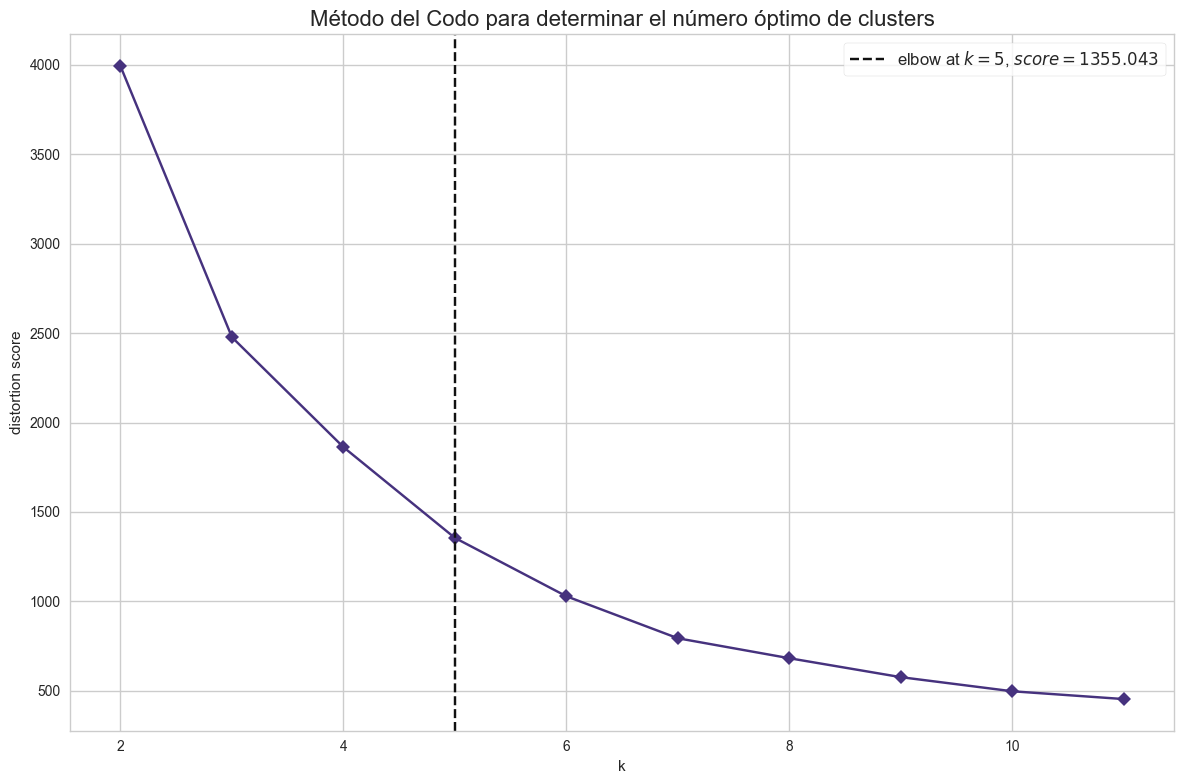

Número óptimo de clusters identificado: k=5
Para k=2, el coeficiente de silueta es: 0.888
Para k=3, el coeficiente de silueta es: 0.532
Para k=4, el coeficiente de silueta es: 0.553
Para k=5, el coeficiente de silueta es: 0.557
Para k=6, el coeficiente de silueta es: 0.474
Para k=7, el coeficiente de silueta es: 0.486
Para k=8, el coeficiente de silueta es: 0.493
Para k=9, el coeficiente de silueta es: 0.458
Para k=10, el coeficiente de silueta es: 0.436


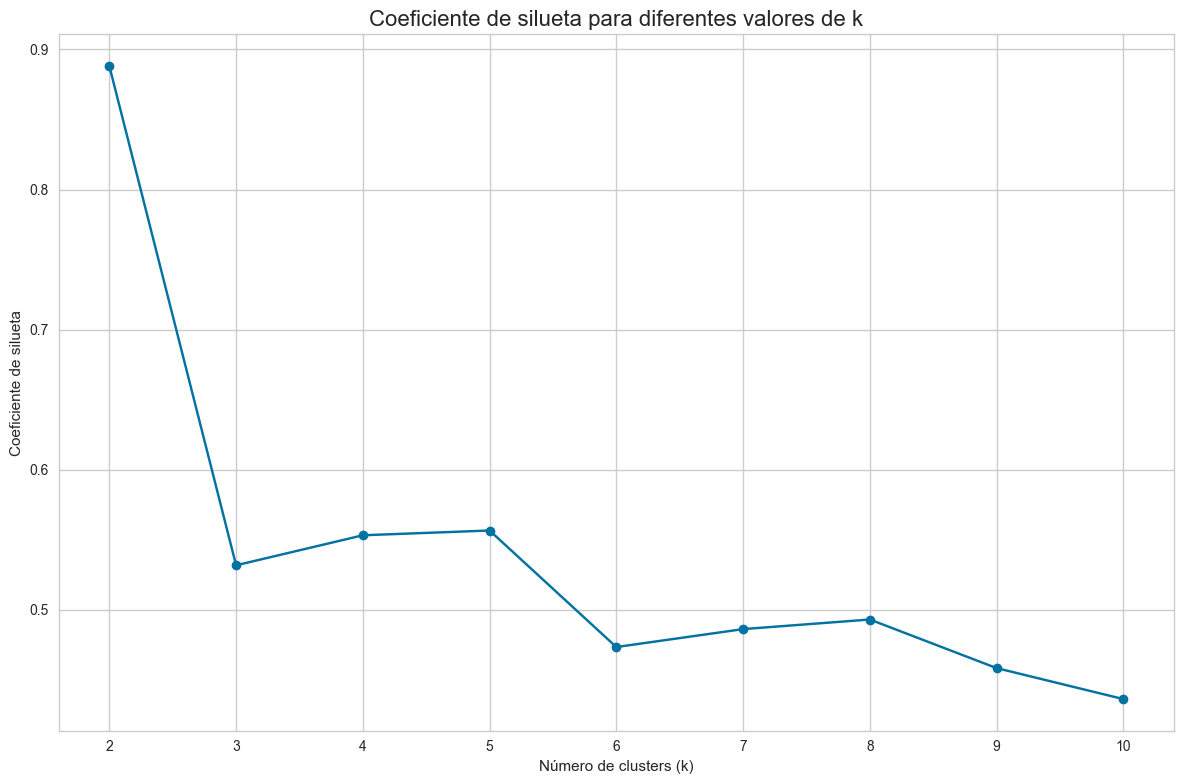

Número óptimo de clusters según coeficiente de silueta: k=2
Los métodos no coinciden exactamente. Se usará k=5 basado en el método del codo y la interpretación empresarial.

Centroides de los clusters:
      Recency   Frequency       Monetary  Cluster
0    5.808511   17.691489   12855.508191        0
1   24.061773    3.569767    1414.011715        1
2  111.886179    1.575203     648.043661        2
3    0.666667  109.000000   50755.240000        3
4    2.250000   30.500000  159714.475000        4


In [5]:
# 4. ENTRENAMIENTO DEL MODELO K-MEANS (EJERCICIO 2)
print("\n4. ENTRENAMIENTO DEL MODELO K-MEANS")
print("-" * 50)

# Preparamos los datos para el clustering
# Extraemos las métricas RFM para el modelo
X = rfm_final[['Recency', 'Frequency', 'Monetary']].copy()

# Normalizamos los datos para el modelo K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'])

# Determinamos el número óptimo de clusters usando el método del codo 
def plot_elbow_method(X_scaled, k_range=(2, 12)):
    """
    Implementa correctamente el método del codo para determinar el número óptimo de clusters.
    """
    # Configurar figura
    plt.figure(figsize=(12, 8))
    
    # Crear visualizador con semilla aleatoria fija
    visualizer = KElbowVisualizer(
        KMeans(random_state=42, n_init=10), 
        k=k_range,
        metric='distortion',
        timings=False
    )
    
    # Ajustar el visualizador a los datos
    visualizer.fit(X_scaled)
    
    # Guardar y mostrar el gráfico
    visualizer.finalize()
    plt.title('Método del Codo para determinar el número óptimo de clusters', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'elbow_method.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Determinar el codo (si existe)
    elbow_value = visualizer.elbow_value_
    
    return elbow_value

# Aplicar método del codo
optimal_k = plot_elbow_method(X_scaled)

# Validar el resultado del método del codo
if optimal_k is None:
    # Si el método no identifica un codo claro, usar un valor predeterminado basado en el negocio
    optimal_k = 5
    print(f"No se identificó un codo claro. Se usará k={optimal_k} como valor predeterminado.")
else:
    print(f"Número óptimo de clusters identificado: k={optimal_k}")

# Validar con el método de la silueta
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Para k={k}, el coeficiente de silueta es: {silhouette_avg:.3f}")

# Visualizar los coeficientes de silueta
plt.figure(figsize=(12, 8))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Coeficiente de silueta')
plt.title('Coeficiente de silueta para diferentes valores de k', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'silhouette_scores.png'), dpi=300, bbox_inches='tight')
plt.show()

# Comparar resultados de ambos métodos
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"Número óptimo de clusters según coeficiente de silueta: k={optimal_k_silhouette}")

# Decisión final sobre el número de clusters
if optimal_k is not None and optimal_k == optimal_k_silhouette:
    print(f"Ambos métodos coinciden en k={optimal_k}, se usará este valor.")
else:
    print(f"Los métodos no coinciden exactamente. Se usará k={optimal_k} basado en el método del codo y la interpretación empresarial.")

# Aplicamos K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_final['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculamos los centroides para cada cluster
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                        columns=['Recency', 'Frequency', 'Monetary'])
centroids['Cluster'] = range(optimal_k)

print("\nCentroides de los clusters:")
print(centroids)

## ANÁLISIS DE RESULTADOS
---


5. ANÁLISIS DE RESULTADOS
--------------------------------------------------

Estadísticas por cluster:


Recency                Frequency            Monetary             \
           mean min  max count      mean min  max       mean        min   
Cluster                                                                   
0          5.81   0   38    94     17.69   8   46   12855.51     395.69   
1         23.97   0   67  1373      3.58   1   12    1416.28      15.00   
2        111.61  66  182   495      1.57   1   10     646.38       7.90   
3          0.67   0    1     3    109.00  74  135   50755.24   23705.23   
4          2.25   0    8     4     30.50   1   46  159714.48  138790.53   

                    
               max  
Cluster             
0         74030.63  
1         14220.23  
2         39916.50  
3        100435.38  
4        168469.60

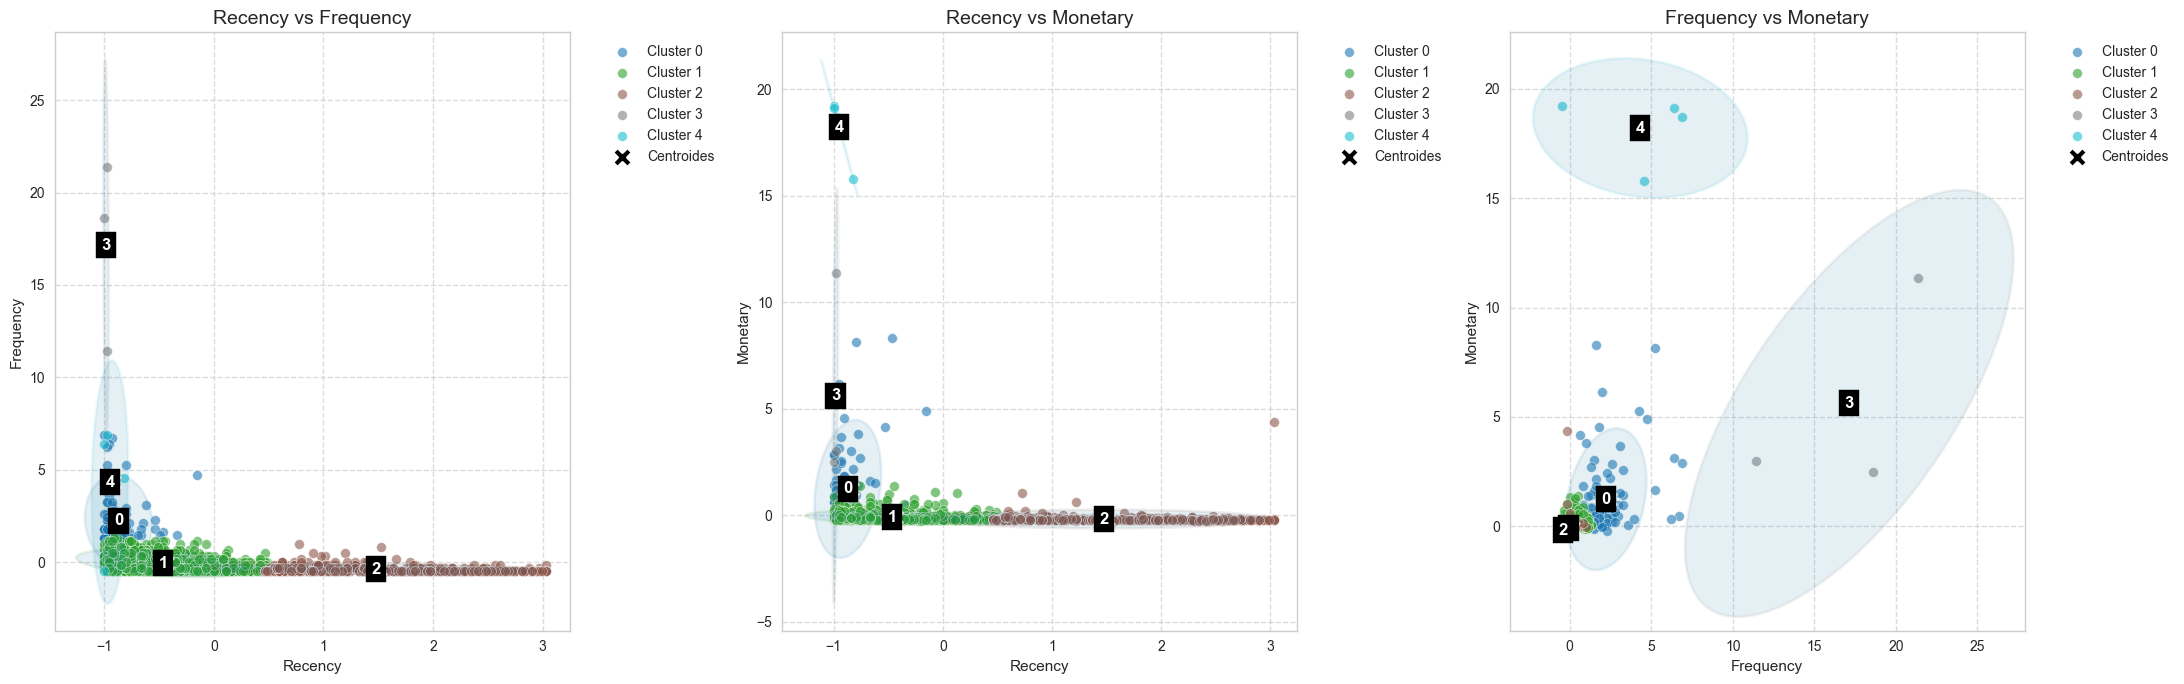

In [6]:
# 5. ANÁLISIS DE RESULTADOS
print("\n5. ANÁLISIS DE RESULTADOS")
print("-" * 50)

# Añadimos las métricas escaladas al dataframe original para visualización
rfm_with_clusters = pd.concat([rfm_final, X_scaled_df], axis=1)

# Estadísticas descriptivas por cluster
cluster_stats = rfm_final.groupby('Cluster').agg({
    'Recency': ['mean', 'min', 'max', 'count'],
    'Frequency': ['mean', 'min', 'max'],
    'Monetary': ['mean', 'min', 'max']
}).round(2)

print("\nEstadísticas por cluster:")
display(cluster_stats)

# Visualización de los clústers
def draw_enhanced_scatter(X_scaled_df, rfm_final, centroids_scaled, feature_x, feature_y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Asignamos colores más distintivos
    colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(rfm_final['Cluster']))))
    
    # Graficamos cada cluster con un color diferente
    for i, color in enumerate(colors):
        # Filtramos los puntos del cluster actual
        mask = rfm_final['Cluster'] == i
        cluster_points = X_scaled_df[mask]
        
        # Dibujamos los puntos del cluster
        ax.scatter(
            cluster_points[feature_x], 
            cluster_points[feature_y],
            s=50, 
            c=[color], 
            label=f'Cluster {i}',
            alpha=0.6,
            edgecolor='w',
            linewidth=0.5
        )
        
        # Calculamos elipses de confianza (95%)
        if sum(mask) > 2:  # Necesitamos al menos 3 puntos para calcular la covarianza
            # Obtenemos los datos del cluster actual
            x = cluster_points[feature_x].values
            y = cluster_points[feature_y].values
            
            # Calculamos la covarianza
            cov = np.cov(x, y)
            
            # Calculamos los eigenvalues y eigenvectors
            lambdas, v = np.linalg.eig(cov)
            sort_indices = np.argsort(lambdas)[::-1]
            lambdas = lambdas[sort_indices]
            v = v[:, sort_indices]
            
            # Ángulo de la elipse (en radianes)
            theta = np.arctan2(v[1, 0], v[0, 0])
            
            # Dibujamos la elipse (escalado para el 95% de confianza)
            confidence = 1.96  # ~95% de confianza
            
            # Creamos la elipse
            ellipse = Ellipse(
                xy=(np.mean(x), np.mean(y)),
                width=2 * confidence * np.sqrt(lambdas[0]),
                height=2 * confidence * np.sqrt(lambdas[1]),
                angle=np.degrees(theta),
                edgecolor=color,
                fill=True,
                alpha=0.1,
                linewidth=2
            )
            ax.add_patch(ellipse)
    
    # Dibujamos los centroides
    feature_x_index = X_scaled_df.columns.get_loc(feature_x)
    feature_y_index = X_scaled_df.columns.get_loc(feature_y)
    ax.scatter(
        centroids_scaled[:, feature_x_index],
        centroids_scaled[:, feature_y_index], 
        s=200, 
        c='black', 
        marker='X', 
        label='Centroides',
        edgecolor='white',
        linewidth=2
    )
    
    # Añadimos etiquetas a los centroides
    for i, centroid in enumerate(centroids_scaled):
        ax.annotate(
            f"{i}", 
            (centroid[feature_x_index], centroid[feature_y_index]),
            fontsize=12,
            fontweight='bold',
            color='white',
            backgroundcolor='black',
            ha='center',
            va='center'
        )
    
    # Configuraciones adicionales
    ax.set_xlabel(feature_x.replace('_scaled', ''))
    ax.set_ylabel(feature_y.replace('_scaled', ''))
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Añadimos título y leyenda
    ax.set_title(f'{feature_x.replace("_scaled", "")} vs {feature_y.replace("_scaled", "")}', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    return ax

# Implementación para mejorar los gráficos de dispersión
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Preparamos los centroides escalados
centroids_scaled = kmeans.cluster_centers_

# Generamos los tres gráficos 
draw_enhanced_scatter(X_scaled_df, rfm_final, centroids_scaled, 'Recency_scaled', 'Frequency_scaled', ax=axes[0])
draw_enhanced_scatter(X_scaled_df, rfm_final, centroids_scaled, 'Recency_scaled', 'Monetary_scaled', ax=axes[1])
draw_enhanced_scatter(X_scaled_df, rfm_final, centroids_scaled, 'Frequency_scaled', 'Monetary_scaled', ax=axes[2])

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'rfm_enhanced_clusters.png'), dpi=300, bbox_inches='tight')
plt.show()

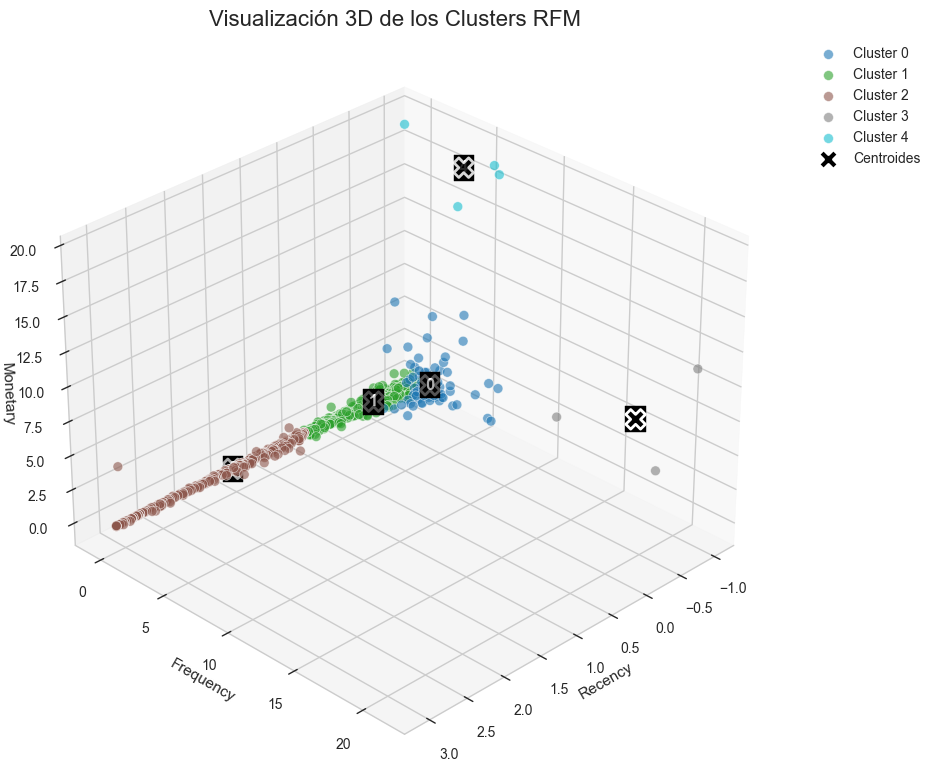

In [7]:
# Visualización 3D de los clústers
def plot_3d_clusters(X_scaled_df, rfm_final, centroids_scaled):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Asignamos colores a cada cluster
    colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(rfm_final['Cluster']))))
    
    # Graficamos cada cluster
    for i, color in enumerate(colors):
        mask = rfm_final['Cluster'] == i
        ax.scatter(
            X_scaled_df.loc[mask, 'Recency_scaled'],
            X_scaled_df.loc[mask, 'Frequency_scaled'],
            X_scaled_df.loc[mask, 'Monetary_scaled'],
            s=50, 
            c=[color], 
            label=f'Cluster {i}',
            alpha=0.6,
            edgecolor='w',
            linewidth=0.5
        )
    
    # Dibujamos los centroides
    ax.scatter(
        centroids_scaled[:, 0],
        centroids_scaled[:, 1],
        centroids_scaled[:, 2],
        s=200, 
        c='black', 
        marker='X', 
        label='Centroides',
        edgecolor='white',
        linewidth=2
    )
    
    # Añadimos etiquetas a los centroides
    for i, centroid in enumerate(centroids_scaled):
        ax.text(centroid[0], centroid[1], centroid[2], f"{i}", 
                fontsize=12, fontweight='bold', color='white', 
                backgroundcolor='black', ha='center', va='center')
    
    # Configuraciones adicionales
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    ax.set_title('Visualización 3D de los Clusters RFM', fontsize=16)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Añadimos una rotación para mejor visualización
    ax.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'rfm_3d_clusters.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Implementación de la visualización 3D
plot_3d_clusters(X_scaled_df, rfm_final, centroids_scaled)

In [8]:
# 6. CARACTERIZACIÓN DE LOS CLUSTERS
print("\n6. CARACTERIZACIÓN DE LOS CLUSTERS")
print("-" * 50)

# Calculamos estadísticas detalladas por cluster para facilitar la interpretación
detailed_stats = rfm_final.groupby('Cluster').agg({
    'CustomerID': 'count',
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'sum']
}).round(2)

# Calculamos el valor total por cluster y el valor promedio por cliente
detailed_stats['Valor_Total_Monetario'] = detailed_stats[('Monetary', 'sum')]
detailed_stats['Porcentaje_Clientes'] = (detailed_stats[('CustomerID', 'count')] / len(rfm_final) * 100).round(2)

# Mostramos las estadísticas detalladas
print("\nEstadísticas detalladas por cluster:\n")
display(detailed_stats)

# Definimos perfil de clientes según los clusters
cluster_profiles = []

for i in range(optimal_k):
    cluster_data = {
        'Cluster': i,
        'Tamaño': detailed_stats.loc[i, ('CustomerID', 'count')],
        'Porcentaje': f"{detailed_stats.loc[i, 'Porcentaje_Clientes']}%",
        'Recencia_Media': detailed_stats.loc[i, ('Recency', 'mean')],
        'Frecuencia_Media': detailed_stats.loc[i, ('Frequency', 'mean')],
        'Valor_Medio': detailed_stats.loc[i, ('Monetary', 'mean')],
        'Valor_Total_Monetario': detailed_stats.loc[i, 'Valor_Total_Monetario']
    }
    cluster_profiles.append(cluster_data)

# Creamos y guardamos un DataFrame con los perfiles
profiles_df = pd.DataFrame(cluster_profiles)
profiles_df['Valor_Total_Monetario'] = profiles_df['Cluster'].map(lambda x: detailed_stats.loc[x, ('Monetary', 'sum')])

# Ordenamos los clusters por valor monetario total para identificar su importancia
profiles_sorted = profiles_df.sort_values('Valor_Total_Monetario', ascending=False)
print("\nClusters ordenados por valor (monetario) total:\n")
display(profiles_sorted)


6. CARACTERIZACIÓN DE LOS CLUSTERS
--------------------------------------------------

Estadísticas detalladas por cluster:



CustomerID Recency        Frequency          Monetary             \
             count    mean median      mean median       mean     median   
Cluster                                                                    
0               94    5.81    3.0     17.69   15.0   12855.51    7137.20   
1             1373   23.97   21.0      3.58    3.0    1416.28     968.01   
2              495  111.61  105.0      1.57    1.0     646.38     347.75   
3                3    0.67    1.0    109.00  118.0   50755.24   28125.11   
4                4    2.25    0.5     30.50   37.5  159714.48  165798.88   

                    Valor_Total_Monetario Porcentaje_Clientes  
                sum                                            
Cluster                                                        
0        1208417.77            1208417.77                4.77  
1        1944557.80            1944557.80               69.73  
2         319959.80             319959.80               25.14  
3         152265.72             152265.72                0.15  
4         638857.90             638857.90                0.20


Clusters ordenados por valor (monetario) total:



,Cluster,Tamaño,Porcentaje,Recencia_Media,Frecuencia_Media,Valor_Medio,Valor_Total_Monetario
1,1,1373,"69.73\nName: 1, dtype: float64%",23.97,3.58,1416.28,1944557.80
0,0,94,"4.77\nName: 0, dtype: float64%",5.81,17.69,12855.51,1208417.77
4,4,4,"0.2\nName: 4, dtype: float64%",2.25,30.50,159714.48,638857.90
2,2,495,"25.14\nName: 2, dtype: float64%",111.61,1.57,646.38,319959.80
3,3,3,"0.15\nName: 3, dtype: float64%",0.67,109.00,50755.24,152265.72


## NOMBRAR Y DESCRIBIR LOS CLUSTERS
---

In [9]:
# 7. NOMBRAR Y DESCRIBIR LOS CLUSTERS
print("\n7. NOMBRAR Y DESCRIBIR LOS CLUSTERS")
print("-" * 50)

# Calcular los valores medios generales para tener referencias
avg_tamaño = profiles_df['Tamaño'].mean()
avg_recency = profiles_df['Recencia_Media'].mean()
avg_frequency = profiles_df['Frecuencia_Media'].mean()
avg_monetary = profiles_df['Valor_Medio'].mean()

# Definir los nombres de clusters basados en las características relativas
cluster_descriptions = {}

for i in range(optimal_k):
    # Obtener valores medios para el cluster
    tamaño = profiles_df.loc[i, 'Tamaño']
    recency = profiles_df.loc[i, 'Recencia_Media']
    frequency = profiles_df.loc[i, 'Frecuencia_Media']
    monetary = profiles_df.loc[i, 'Valor_Medio']
    
    # Caracterizar cada dimensión RFM (bajo, medio, alto)
    r_status = "Reciente" if recency < avg_recency else "No reciente"
    f_status = "Alta frecuencia" if frequency > avg_frequency else "Baja frecuencia"
    m_status = "Alto valor" if monetary > avg_monetary * 1.5 else "Valor medio" if monetary > avg_monetary * 0.5 else "Bajo valor"
    size_status = "Grande" if tamaño > avg_tamaño else "Pequeño"
    
    # Lógica de asignación de nombres basada en las características
    if r_status == "Reciente" and f_status == "Alta frecuencia" and m_status == "Alto valor":
        description = "Clientes Champions" if monetary > avg_monetary * 5 else "Clientes VIP"
    elif r_status == "Reciente" and f_status == "Alta frecuencia":
        description = "Clientes Leales"
    elif r_status == "Reciente" and m_status == "Alto valor":
        description = "Grandes Compradores Recientes"
    elif r_status == "No reciente" and f_status == "Alta frecuencia" and m_status == "Alto valor":
        description = "Clientes VIP en Riesgo"
    elif r_status == "No reciente" and f_status == "Baja frecuencia" and m_status == "Bajo valor":
        description = "Clientes Ocasionales de Bajo Valor"
    elif r_status == "No reciente" and f_status == "Baja frecuencia":
        description = "Clientes Inactivos"
    elif r_status == "Reciente" and f_status == "Baja frecuencia" and size_status == "Pequeño":
        description = "Nuevos Clientes Potenciales"
    else:
        description = "Clientes Promedio"
    
    cluster_descriptions[i] = description

# Añadir las descripciones al DataFrame de perfiles
profiles_df['Descripción'] = profiles_df['Cluster'].map(cluster_descriptions)

print("Descripción de los clusters:")
display(profiles_df[['Cluster', 'Descripción', 'Tamaño', 'Porcentaje', 'Recencia_Media', 'Frecuencia_Media', 'Valor_Medio']])


7. NOMBRAR Y DESCRIBIR LOS CLUSTERS
--------------------------------------------------
Descripción de los clusters:


,Cluster,Descripción,Tamaño,Porcentaje,Recencia_Media,Frecuencia_Media,Valor_Medio
0,0,Nuevos Clientes Potenciales,94,"4.77\nName: 0, dtype: float64%",5.81,17.69,12855.51
1,1,Clientes Promedio,1373,"69.73\nName: 1, dtype: float64%",23.97,3.58,1416.28
2,2,Clientes Ocasionales de Bajo Valor,495,"25.14\nName: 2, dtype: float64%",111.61,1.57,646.38
3,3,Clientes Leales,3,"0.15\nName: 3, dtype: float64%",0.67,109.00,50755.24
4,4,Grandes Compradores Recientes,4,"0.2\nName: 4, dtype: float64%",2.25,30.50,159714.48


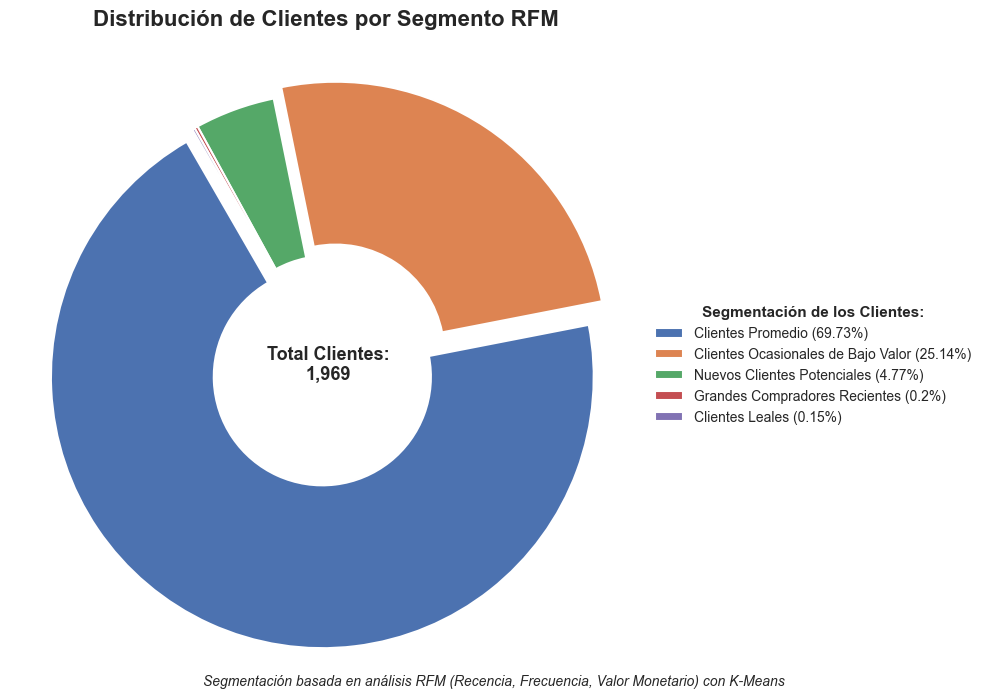

In [10]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm

# Calcular el porcentaje de clientes que representa cada segmento
profiles_df['Porcentaje_Clientes'] = (profiles_df['Tamaño'] / profiles_df['Tamaño'].sum() * 100).round(2)

# Crear colores personalizados 
colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B3', '#937860']

# Ordenar los segmentos por tamaño para mejor visualización
profiles_df_sorted = profiles_df.sort_values(by='Tamaño', ascending=False).reset_index(drop=True)

# Crear un DataFrame para etiquetas más informativas
df_pie = profiles_df_sorted.copy()

# Configurar el gráfico con mayor calidad
plt.figure(figsize=(10, 7), dpi=100)
plt.rcParams.update({'font.size': 11, 'font.family': 'Arial'})

# Crear el gráfico de donut
wedges, texts = plt.pie(
    df_pie['Tamaño'],
    startangle=120,  # Ajustar el ángulo inicial
    colors=colors[:len(df_pie)],
    wedgeprops={
        'width': 0.6,  # Controla el grosor del donut
        'edgecolor': 'white',
        'linewidth': 1.5
    },
    explode=[0.05 if size > df_pie['Tamaño'].mean() else 0 for size in df_pie['Tamaño']],  # Resaltar segmentos grandes
    shadow=False  # Sin sombra para un estilo más limpio
)

# Añadir una leyenda 
legend_labels = [
    f"{row['Descripción']} ({row['Porcentaje_Clientes']}%)"
    for _, row in df_pie.iterrows()
]

plt.legend(
    handles=wedges,  # Usar los objetos generados por plt.pie
    labels=legend_labels,  # Etiquetas con descripción y porcentaje
    title="Segmentación de los Clientes:",
    title_fontproperties=fm.FontProperties(weight='bold'),
    loc="center left",
    bbox_to_anchor=(1, 0.5),  # Posicionar la leyenda fuera del gráfico
    fontsize=10
)

# Añadir título
plt.title('Distribución de Clientes por Segmento RFM', fontsize=16, fontweight='bold', pad=20)

# Añadir texto en el centro del gráfico
plt.annotate(
    f"Total Clientes:\n{df_pie['Tamaño'].sum():,}",
    xy=(0, 0),
    fontsize=13,
    fontweight='bold',
    ha='center',
    va='center'
)

# Añadir una nota explicativa
plt.figtext(
    0.5, 0.01,
    "Segmentación basada en análisis RFM (Recencia, Frecuencia, Valor Monetario) con K-Means",
    ha='center',
    fontsize=10,
    fontstyle='italic'
)

plt.axis('equal')  # Para mantener aspecto circular
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'distribucion_segmentos_clientes.png'), dpi=300, bbox_inches='tight')
plt.show()

## VISUALIZACIONES EXTRAS
---


8. ANÁLISIS VISUAL EXTRA
--------------------------------------------------


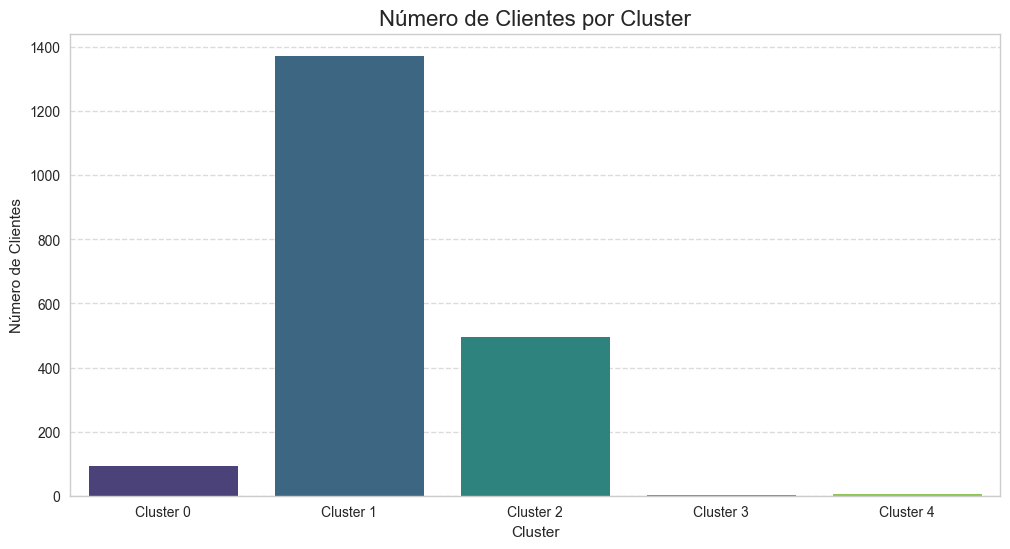

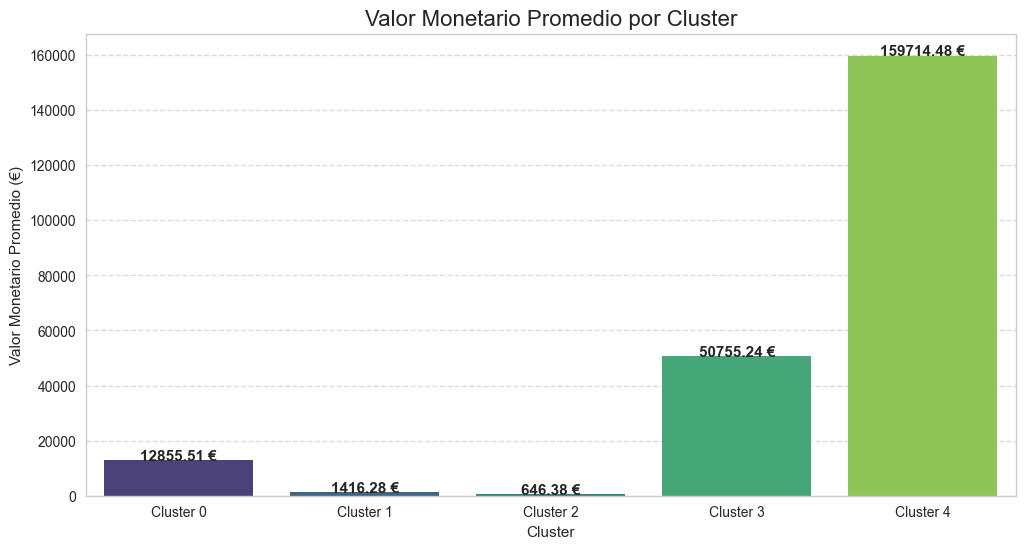

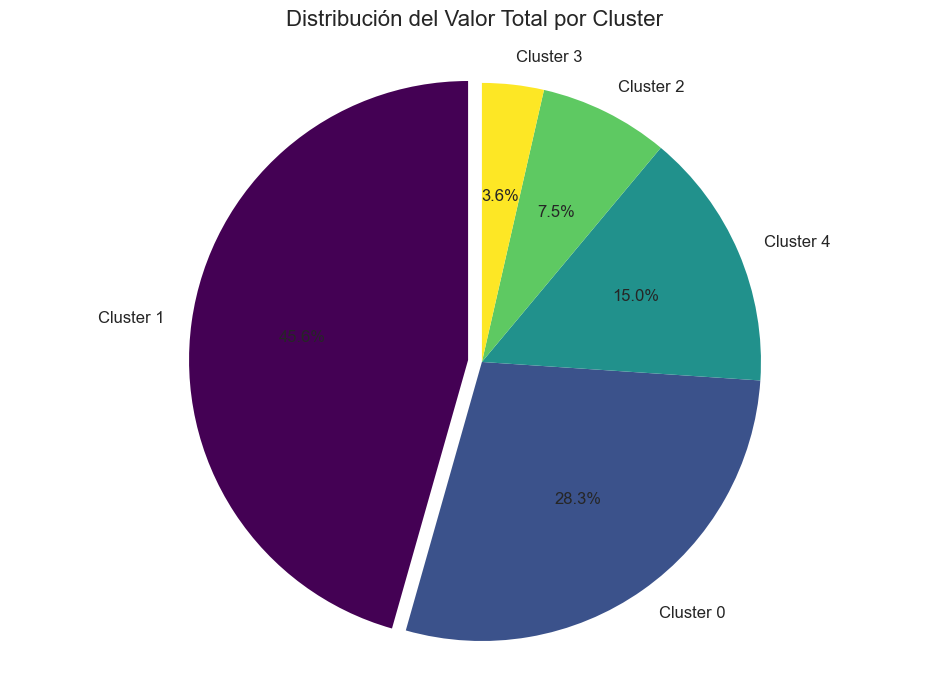

In [11]:
# 8. ANÁLISIS VISUAL EXTRA
print("\n8. ANÁLISIS VISUAL EXTRA")
print("-" * 50)

# Gráfico de barras para mostrar la distribución de clientes por cluster
plt.figure(figsize=(12, 6))
sns.barplot(x=profiles_df['Cluster'], y=profiles_df['Tamaño'], palette='viridis')
plt.title('Número de Clientes por Cluster', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.xticks(ticks=range(optimal_k), labels=[f"Cluster {i}" for i in range(optimal_k)])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(os.path.join(output_folder, 'cluster_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Gráfico de barras para mostrar el valor monetario promedio por cluster
plt.figure(figsize=(12, 6))
sns.barplot(x=profiles_df['Cluster'], y=profiles_df['Valor_Medio'], palette='viridis')
plt.title('Valor Monetario Promedio por Cluster', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Valor Monetario Promedio (€)')
plt.xticks(ticks=range(optimal_k), labels=[f"Cluster {i}" for i in range(optimal_k)])
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(profiles_df['Valor_Medio']):
    plt.text(i, v + 5, f"{v:.2f} €", fontweight='bold', ha='center')

plt.savefig(os.path.join(output_folder, 'cluster_avg_monetary.png'), dpi=300, bbox_inches='tight')
plt.show()

# Visualización de proporciones de valor
plt.figure(figsize=(12, 8))
cluster_value_data = profiles_df.sort_values('Valor_Total_Monetario', ascending=False).copy()
cluster_value_data['Porcentaje_Valor'] = (cluster_value_data['Valor_Total_Monetario'] / cluster_value_data['Valor_Total_Monetario'].sum() * 100).round(2)
plt.pie(cluster_value_data['Valor_Total_Monetario'], 
        labels=[f"Cluster {i}" for i in cluster_value_data['Cluster']],
        autopct='%1.1f%%',
        startangle=90,
        shadow=False,
        explode=[0.05] + [0]*len(cluster_value_data[1:]),
        textprops={'fontsize': 12},
        colors=plt.cm.viridis(np.linspace(0, 1, len(cluster_value_data))))
plt.axis('equal')
plt.title('Distribución del Valor Total por Cluster', fontsize=16, pad=20)
plt.savefig(os.path.join(output_folder, 'cluster_value_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# 9. GUARDAR RESULTADOS PARA EL INFORME
print("\n9. GUARDANDO RESULTADOS PARA EL INFORME")
print("-" * 50)

# Guardamos el DataFrame RFM con los clusters asignados
rfm_final.to_csv('rfm_with_clusters.csv', index=False)
print("DataFrame RFM con clusters guardado como 'rfm_with_clusters.csv'")

# Guardamos las estadísticas por cluster para el informe
profiles_df.to_csv('cluster_profiles.csv', index=False)
print("Perfiles de clusters guardados como 'cluster_profiles.csv'")

print("\nAnálisis RFM y K-Means completado con éxito!")


9. GUARDANDO RESULTADOS PARA EL INFORME
--------------------------------------------------
DataFrame RFM con clusters guardado como 'rfm_with_clusters.csv'
Perfiles de clusters guardados como 'cluster_profiles.csv'

Análisis RFM y K-Means completado con éxito!
